In [182]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm 
import seaborn as sns
import arviz as az
import theano.tensor as tt
import corner

<ErrorbarContainer object of 3 artists>

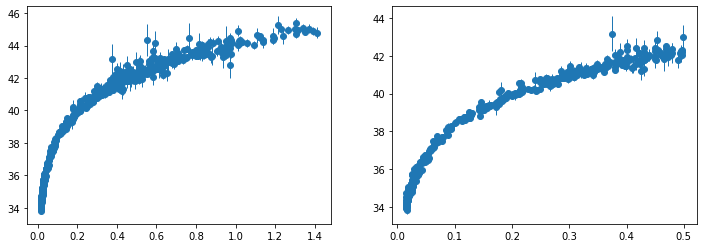

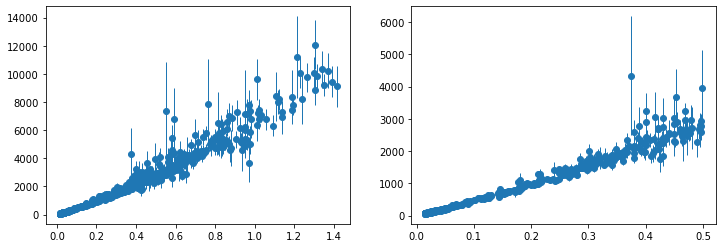

In [60]:
z = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 1)
mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 2)
delta_mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 3)
data4 = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 4)

### sort data
sortOrder = np.argsort(z)
z = z[sortOrder]
mu = mu[sortOrder]
delta_mu = delta_mu[sortOrder]

low_ind = np.where(z<0.5)
low_z = z[low_ind]
low_mu = mu[low_ind]
low_delta_mu = delta_mu[low_ind]

dl = 10**(mu/5-5)
delta_dl = dl*np.log(10)*delta_mu/5
low_dl = 10**(low_mu/5-5)
low_delta_dl = low_dl*np.log(10)*low_delta_mu/5

### plot the data
fig,ax = plt.subplots(1,2, figsize = (12,4))
ax[0].scatter(z,mu)
ax[0].errorbar(z,mu,delta_mu, linewidth = 0, elinewidth = 1)
ax[1].scatter(low_z,low_mu)
ax[1].errorbar(low_z,low_mu,low_delta_mu, linewidth = 0, elinewidth = 1)

fig,ax = plt.subplots(1,2, figsize = (12,4))
ax[0].scatter(z,dl)
ax[0].errorbar(z,dl,delta_dl, linewidth = 0, elinewidth = 1)
ax[1].scatter(low_z,low_dl)
ax[1].errorbar(low_z,low_dl,low_delta_dl, linewidth = 0, elinewidth = 1)

In [79]:
c = 1
def mu_model(z, H0, q0):
    return np.log10(dl_model(z,H0,q0))*5 + 25
    
def dl_model(z, H0, q0):
    return c/H0*(z + 1/2*(1-q0)*z**2)

In [245]:
W = np.diag(low_delta_mu**(-2))
W_dl = len(low_z)*(low_delta_dl**(-2))/((low_delta_dl**(-2)).sum())
cov = np.diag(1/W_dl)
 
our_mu_model = pm.Model()
with our_mu_model:
    

    #H0 = pm.Uniform("H0", lower = -10, upper = 10, shape = 1)
    theta = pm.Uniform("theta", lower = 10, upper = 10000, shape = 1) # theta = 1/H0
    q0 = pm.Uniform("q0", lower = -100, upper = 100, shape = 1)
    
    sigma2 = pm.InverseGamma("sigma2", 1, 1)
    
    dl = c*theta*(low_z + 1/2*(1-q0)*low_z**2)
    mu_m = np.log10(dl)*5 + 25

    #mu_obs = pm.Normal('mu_obs', mu=mu_m, sd=tt.sqrt(sigma2), observed=low_mu)
    mu_obs = pm.MvNormal('mu_obs', mu=mu_m, cov= sigma2*np.diag(low_delta_mu**2), observed=low_mu)
    

    
our_dl_model = pm.Model()
with our_dl_model:
    theta = pm.Uniform("theta", lower = 0, upper = 0.01, shape = 1)
    q0 = pm.Uniform("q0", lower = -100, upper = 100, shape = 1)
    
    sigma2 = pm.InverseGamma("sigma2", 1, 1)
    
    dl = 1/theta*(low_z + 1/2*(1-q0)*low_z**2)
    #dl = theta*low_z + 1/2*theta*(1 - q0)*low_z**2
    
    dl_obs = pm.MvNormal('dl_obs', mu=dl, cov= (sigma2)*cov, observed=low_dl)
    #mu_obs = pm.MvNormal('mu_obs', mu=mu_m, cov= sigma2*np.diag(low_delta_mu**2), observed=low_mu)

In [246]:
#map_estimate = pm.find_MAP(model=our_mu_model)
map_estimate = pm.find_MAP(model=our_dl_model)

H0 = map_estimate['theta'][0]
q0 = map_estimate['q0'][0]
s2  = map_estimate['sigma2']

print(f'[theta_0,theta_1] = [{H0:.4f},{q0:.3f}] and [sigma2] = {s2:.3f}')


[theta_0,theta_1] = [0.0002,-0.409] and [sigma2] = 177.074


In [236]:
#with our_mu_model:
#    trace_NUTS = pm.sample(1000)
    
with our_dl_model:
    trace_NUTS = pm.sample(100)
    

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2, q0, theta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 347 seconds.


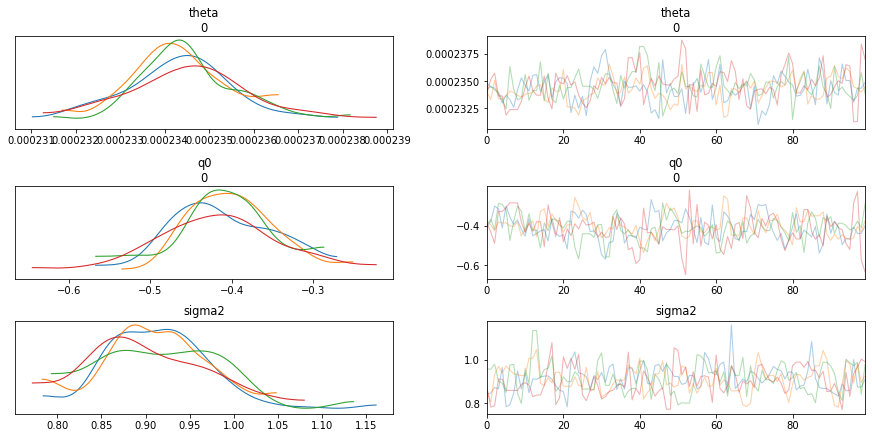

In [237]:
with our_dl_model:
    az.plot_trace(trace_NUTS);

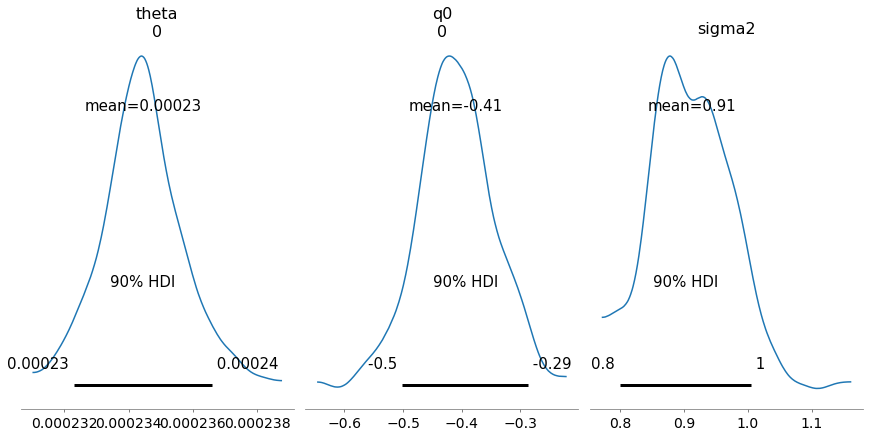

In [238]:
# or plot only marginalized posteriors with some mean and highest_density_intervals
with our_dl_model:
    az.plot_posterior(trace_NUTS,figsize=(12, 6),hdi_prob=0.9);

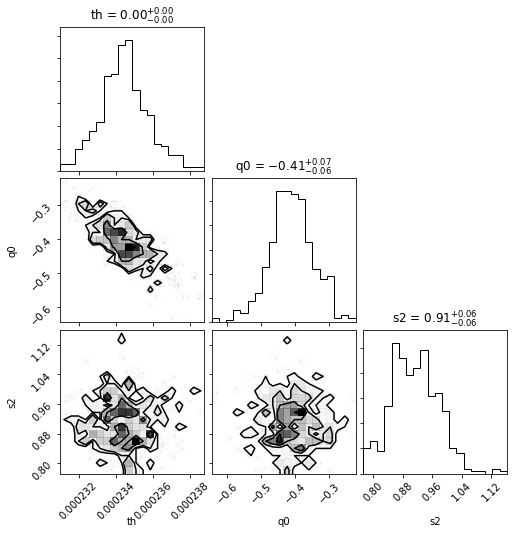

In [239]:
# you can stack the traces and plot them using corner

#samples = np.vstack([trace_NUTS['theta'][:,k] for k in range(0,len(trace_NUTS['theta'][0]))])
samples = np.vstack(trace_NUTS['theta'][:]).T
samples = np.vstack((samples,trace_NUTS['q0'][:].T))
samples = np.vstack((samples,(trace_NUTS['sigma2'][:]).T)).T

fig_corner = corner.corner(samples,labels =['th', 'q0','s2'],show_titles=True);


/Users/kevinandersson/opt/miniconda3/envs/Physics-env/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


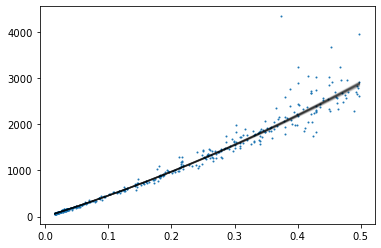

In [241]:
with our_dl_model:
    posterior_draws = pm.sample_posterior_predictive(trace_NUTS, var_names=["theta", "q0", "sigma2"], 
                                                     samples=40, random_seed=123);

for idx, theta_sample in enumerate(posterior_draws['theta']):
    epsilon = np.random.normal(scale=np.sqrt(posterior_draws['sigma2'][idx]))
    plt.plot(low_z, dl_model(low_z, theta_sample,posterior_draws['q0'][idx]) + epsilon,color='black',alpha=0.05)
plt.scatter(low_z,low_dl, s = 1)